# Classification

Classification in a supervised learning task along with regression. It is used in predicting classes i.e. it is used to predict categorical data.
In this notebook the following topics will be covered: -
1. Using MNIST Dataset
2. Training a Binary Classifier
3. Performance Measures
4. Multiclass Classification
5. Error Analysis
6. Multilabel Classification
7. Multioutput Classification

## 1. Using MNIST Dataset

The dataset we will be using for classification is the MNIST dataset, which is a set of 70,000 small images of handwritten digits. Each image is labelled with the digit it represents. This dataset is often used as a way of seeing how new classification algorithms perform.

Scikit-Learn provides many helper functions to download popular datasets. MNIST is one of them. The following code fetches the MNIST dataset.

In [1]:
from sklearn.datasets import fetch_openml

# Used to fetch data from openml using the name or dataset id
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

KeyboardInterrupt: 

Datasets loaded by Scikit learn generally have a similar dictionary structure, including the following:
* A **DESCR** key describing the dataset
* A **data** key containing an array with one row per instance and one column per feature
* A **target** key containing an array with the labels.

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

This shows that there are 70,000 images and each image has 784 features. This is because each image has 28 * 28 pixels, and each feature represents the pixels' intensity.
To see one image we will need to plot it as if we use it normally it will only give us the numeric values.

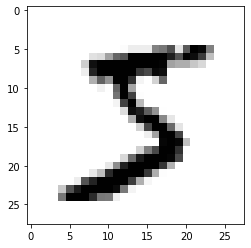

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

img = X.loc[0].to_numpy()
img = img.reshape(28, 28)
plt.imshow(img, cmap="binary")

This looks like a 5 and if we check our target it is indeed a 5

In [4]:
y[0]

'5'

We need to convert this y to an integer in the following manner

In [5]:
y = y.astype(np.uint8)
y[0]

5

Let us now just create a function that we can use to view a random image from X

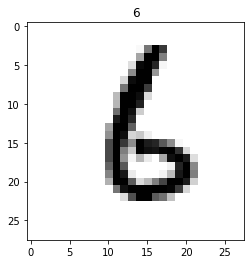

In [6]:
import random

def plot_random_digit():
    num = random.randint(0, len(X))
    random_img = X.loc[num].to_numpy()
    random_img = random_img.reshape(28, 28)
    plt.imshow(random_img, cmap="binary")
    plt.title(y[num])

plot_random_digit()

We need to now create our train and test set, MNIST already has shuffled the order for us normally this is not the case, and so we will have to do it ourselves however in this scenario we can use it directly.
Shuffling is important as some learning algorithms are sensitive to the order of training instances and will perform poorly if they get many similar training instances in a row.

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
len(X_train), len(X_test)

(60000, 10000)

## 2. Training a Binary Classifier

Let's simplify the problem for now and only try to identify one digit, for example the number 4. This 4 detector is an example of binary classification, capable of distinguishing between 2 classes, 4 and not-4.
The target vector needs to first be updated.

In [8]:
# This converts all values to either True or False depending on if it is 4
y_train_4 = (y_train == 4)
y_test_4 = (y_test == 4)

Now we must choose a classifier and train it a good place tp start is with Stochastic Gradient Descent Classifier, using SciKit-Learn's **SGDClassifier** class.
This classifier has the advantage of being capable of handling large datasets very efficiently. This is in part because SGD deals with training instances independently, one at a time
(which also makes it suitable for online learning). We use it as follows: -

In [9]:
from sklearn.linear_model import SGDClassifier

# We use random state so that the results are reproducible
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_4)

SGDClassifier(random_state=42)

The SGD classifier relies on randomness during training and hence the name "stochastic".

We can now use this model to detect images of 4.

In [10]:
img = X_train.loc[0]
sgd_clf.predict([img])

array([False])

Let us visualise this models predictions by selecting an image at random, and plotting its prediction along with the actual label

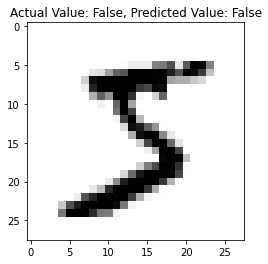

In [11]:
def plot_binary_prediction():
    num = random.randint(0, len(X))
    rand_img = X.loc[0]
    img = rand_img.to_numpy()
    img = img.reshape(28, 28)
    y_4_pred = sgd_clf.predict([rand_img])
    plt.imshow(img, cmap="binary")
    plt.title(f"Actual Value: {y_train_4[num]}, Predicted Value: {y_4_pred[0]}")

plot_binary_prediction()

## 3. Performance Measures

Evaluating a classifier is significantly trickier than evaluating a regressor.
This section will be broken up into the following subsections: -
1. Measuring accuracy using cross-validation
2. Confusion Matrix
3. Precision and Recall
4. Precision/Recall Tradeoff
5. The ROC Curve

### 3.1 Measuring accuracy using Cross-Validation

A good way to evaluate a model is to use cross-validation. Sometimes you may need to have more control over the cross validation proess than what Scikit-Learn provides. In these cases, you can implement it yourself.
The program for cross validation will be given as one of the resources in this chapter.

For now, we will use the cross_val_score() function to evaluate our **SGDClassifier** model, using K-fold cross-validation with three folds. Remember that K-fold cross-validation means splitting the training set into K folds (3 in this case), then making predictions and evaluating them on each fold using a model trained on the remaining folds.

In [12]:
from sklearn.model_selection import cross_val_score
# cv is the number of folds
cross_val_score(sgd_clf, X_train, y_train_4, cv=3, scoring="accuracy")

array([0.9671 , 0.97645, 0.9687 ])

The reason the accuracy is as high as it is, is because the dataset is very skewed. Most of the samples are not 4 and hence if the model always guesses not 4 ie False it will yet get a high accuracy.
To prove this lets look at a very basic classifier that predicts everything in the not-4 class.

In [13]:
from sklearn.base import BaseEstimator

class Never4Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_4_clf = Never4Classifier()
cross_val_score(never_4_clf, X_train, y_train_4, cv=3, scoring="accuracy")

array([0.90275, 0.9018 , 0.90335])

It has over 90% accuracy, thid is only bevause only 10% of images are 4's so if you always guess not a 4 you will still be right 90% of the time.

This shows accuracy is not the preffered performance metric for classifiers, especially when we deal with skewed datasets (i.e. datasets where some classes are more common than others)

### 3.2 Confusion Matrix

Confusion matrix is a much better way to evaluate the performance of a classifier. The concept behind it is to count the number of instances of class A that are classified as class B. For example, to know the number of times the classifier confused images of 4 with images of 3 you would look in the 4th and 3rd column of the confusion matrix.

To compute the confusion matrix first you need to have a set of predictions so that they can be compared to actual targets. You could make predictions on the test set, but lets keep it untouched for now (remember that you want to use the test set only t the end of the project, once you have a classifier that is ready to launch.
Instead, you can use the **cross_val_predict()** function.

In [14]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_4, cv=3)

Just like the **cross_val_score()** function, **cross_val_predict()** performs K-fold cross_validation, but instead of returning the evaluation scores it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set ("clean" meaning prediction is made by a model that never saw the data during training).

Now using this we can get the confusion matrix using the **confusion_matrix()** function by passing target class and predicted class.

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_4, y_train_pred)

array([[52957,  1201],
       [  554,  5288]])

Each row in a confusion matrix represents an actual class, while each column represents predicted class.

The first row considers non-4 images (negative class): of which 52957 were correctly classified as non-4 these are called true negative while remaining 1201 were incorrectly identified as 4 which is called false positive.

The second row considers images of 4 (positive class); of which 554 were wrongly classified as non-4 (false negative) and 5288 were correctly identified as 4s (true positive)

A perfect classifier would only have true positives and true negatives, so its confusion matrix would have nonzero values on its main diagonal (top left to bottom right).

The confusion matrix gives a lot of information, sometimes you may prefer a more concise metrix. An interesting one to look at is the accuracy of the positive predictions, this is called the precision of the classifier.

Precision = TP/(TP + FP) [where TP is true positive and FP is false positive]

A trivial way to have perfect precision is to make one single positive prediction and ensure it is correct (precision = 1/1 = 100%). This however is not useful as classifier would ignore all but one positive instance. So preicison is typically used with anotber metric named recall, also called sensitivity or the true positive rate (TPR) this is the ratio of positive instances that are correctly detected by classifier.

Recall = TP/(TP + FN) [where TP is true positive and FN is false negative]

### 3.3 Precision and Recall

Scikit-Learn provides seberal functions to compute classifier metrics, including precision and recall.

In [16]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_4, y_train_pred), recall_score(y_train_4, y_train_pred)

(0.8149175527816305, 0.905169462512838)

Now your 5 detector does not look as shiny as it did when you looked at its accuracy. When it claims an image represents a 4, it is only correct 81% of the time. It also only detects 90% of the 4s.

It is often convenient to combine precision and recall into a single metric called the F1 score, in particular if you need a simple way to compare two classifiers. The F1 score is the harmonic mean of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight weight to low values. As a result the classifier will get an F1 score if both recall and precision are high.

F1 = 2 * (precision * recall) / (precision + recall)

To compute the F1 score simply call the function.

In [17]:
from sklearn.metrics import f1_score
f1_score(y_train_4, y_train_pred)

0.8576757764982564

The F1 score favors classifiers that have similar precision and recall. This is not always what you want, in some cases you might favour precision and others you might want recall. For example if you trained a classifier to detect videos that are safe for kids you might prefer a classifier that rejects good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but a few bad videos may show up. On the other hand suppose you train a classifier to detect shoplifters, it is probably fine if classifier has only 30% precision as long as it has 99% recall. Unfortunately you cant have it both ways as increasing precision reduces recall and vice versa. This is called the **precision-recall tradeoff**.

### 3.4 Precision/Recall Tradeoff

To understand this lets look at how the SGDClassifier makes it classification decisions. For each instance, it computes a score based on the decision function. If that score is greater than the threshold it assigns the instance to the positive class, otherwise negative.

There may be various threshold for example:

8 7 3 9 t1 5 2 5 t2 5 6 t3 5 5 5

Here everything to the left of t1 is negative predictions and right of t3 is positive.

IF we choose the threshold at t1 we get 75% precision and 100% recall, if we choose t2 we get 80% precision and 67% recall and t3 gives us 100% precision and 50% recall.
As observed as we get a higher precision we get a lower recall.

Scikit_learn does not let you set the threshold directly but it does give you access to the decision scores that it uses to make predicittions. Instead of calling the classifiers predict() method, you can call its decision_function() method which returns a score for each instance, and then uses any threshold you want to make predictions based on those scores.

In [18]:
some_digit = X.loc[2].to_numpy()
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([3214.66574913])

In [19]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

The SGD classifier uses a threshold equal to 0, so the previous code returns same result as the predict() method. LEts raise the threshold

In [20]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. THe image actually represents a 4 but the classifier detects when threshold is 0 and misses when it is set to 8000.

How to decide which threshold to use? First use the cross_val_predict() function to get the scores of all instances in the training setm but this time specify that you want to return decision scores instead of predictions.

In [21]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_4, cv=3, method="decision_function")

With these scores, use the precision_recall_curve() function to compute precision and recall for all ppossible thresholds

In [22]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_4, y_scores)

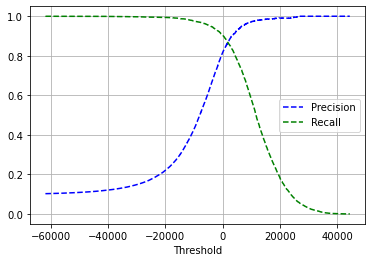

In [23]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend()
    plt.grid()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show();

The reason why the precision curve is bumpier than the recall curve is that the precision may sometimes go down when you raise the threshold althoguh in general it will go up. To understand why when u start to move from central threshold and move only one digit to the right precision goes from 80% down to 75% on the other hand recall can only go down when the threshold increased which is why it looks smooth.

Another way to select a good precision/recall tradeoff is to plot precision directly against recall.
You want to select a precision/recall tradeoff just before the drop.

Text(0, 0.5, 'Precision')

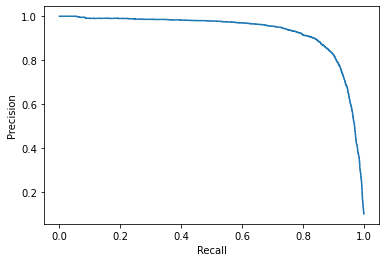

In [24]:
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")

Suppose you decide for a 90% precision. You look up the first plot and find that you need to use a threshold of about 8000. To be more precise you can search for the lowest threshold that will give you 90% precision. (np.argmax() will give you the first index of maximum value, which in this case is the first True value)

In [25]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

To make predictions (on the training set for now), instead of calling the classifiers predict() method, you can run this code.

In [26]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

Lets check these predictions precision and recall.

In [27]:
precision_score(y_train_4, y_train_pred_90), recall_score(y_train_4, y_train_pred_90)

(0.9001287474710318, 0.8377268058883944)

Now you have a 90% precision classifier. A high precision classifier is nt very useful if it has low recall.

### 3.5 The ROC Curve

The reciever operating characteristic (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision recall curve but instead of plotting precision versus recall the ROC curve plots the true positive rate (another name for recall) against the false positive rate (FPR). THe FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 - the true negative rate (TNR) which is the ratio of negative instances that are corrrectly classified as negative. The TNR is also called specificity. Hence the ROC curve plot sensitivity versus specificity.

To plot the ROC curve, you first use te roc_curve() function to compute the TPR and FPR for various threshold values.

In [28]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_4, y_scores)

Then you can plot the FPR against the TPR using matplotlib.

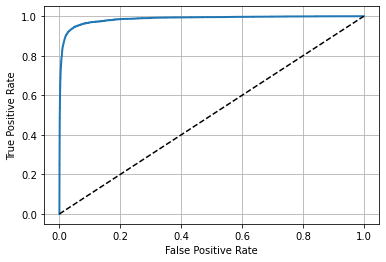

In [29]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0, 1], 'k--') # Dashed Diagonal
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid()

plot_roc_curve(fpr, tpr)
plt.show()

once again there is a tradeoff the higher the recall (TPR) the more false positives the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (towards the top-left corner)

One way to compare classifiers is to measure the are under curve (AUC). A prefect classifier will have ROC AUC equal to 1, were as a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC AUC.

In [30]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_4, y_scores)

0.9859276923382874

Since the ROC curve is so similar to precision/recall curve you may wonder how to decide which one to use. As a rule of thumb you shuld prefer PR curve whenever the positive class is rare or when you care more about false positives than false negatives. Otherwise, use ROC curve.
For example looking at previous ROC curve or ROC AUC score you may think classifier is really good but this is only because there are few positives compared to the negatives. In contrast, PR curve shows there is a lot of room for improvement.

Lets train a RandomForestClassifier and compare its ROC curve and ROC AUC score to SGD classifier, First you need to get scores for each instance in training set. But due to the way it works it does not have a decision_function() method. INstead it has a predict_proba() method. Scikit-learn classifiers generally have one or both. This one returns an array containing a row per instance and a column per class each containing probability that the given instance belongs to a class.

In [31]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=4)
y_probsa_forest = cross_val_predict(forest_clf, X_train, y_train_4, cv=3, method="predict_proba")

The roc_curve() function expects labels and scores but instead of scores you can give it class probabilities, Lets use the positive class probability as the score.

In [32]:
y_scores_forest = y_probsa_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_4, y_scores_forest)

Now we can plot roc curve as see how they compare.

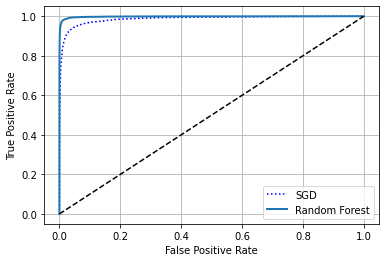

In [33]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest,tpr_forest,"Random Forest")
plt.legend(loc="lower right")
plt.show();

Comparing the ROC curves the Random FOrest Classifier is superior to SGD because the ROC curve is much closer to the top left corener and it has a greater AUC.

In [34]:
roc_auc_score(y_train_4, y_scores_forest)

0.9981869919348789

## 4. Multiclass Classification

While binary classifiers distinguish between two classes, multiclass classifiers can distinguish between more than 2 classes.

Some algorithms like SGDClassifiers, Random forest classifiers and naive Bayes classifiers are capable of handling multiple classes natively. Others such as Logistic Regression Or Support Vector Machine are strictly binary classifiers. However, there are various strategies that you can use to perform multiclass classification with multiple binary classifiers.

One way is to create a system that can classify the digit images into 10 classes from 0 to 9 is to train 10 binary classifiers, 1 for each digit, then when u want to classify an image you get the decision score from each classifier for that image and select the class whose classifier puts the highest score. This is called a **one-versus-the-rest (OvR)** strategy, also called one-versus-all.

Another strategy is to train a binary classifier for every pair of digits one to distinguish 0 and 1 another to distinguish 0 and 2 another for 1 and 2. THis is called one versus one (OvO) strategy. If there are N classes you need to train N * (N-1) / 2 classifiers. For MNIST problem you will hence be training 45 classifiers. When you want to classify an image you run it through all classifiers and see which one wins the most duels.
An advantage of OvO is that classifier needs to only be trained on the part of the training set for the two classes that it must distinguish.

Some algorithms such as Support Vector Machines scale poorly with the size of the training set. For these algorithms OvO is preferred because it is faster to train many classifiers on small training set than few on a large training set. For most binary classification algorithms however, OvR is preferred.

Scikit-Learn detects when you try to use a binary classification for a multi-class classification task, and it will automatically run OvR or OvO depending on the algorithm. Trying this with SVM.

In [35]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train is all the different digits as opposed to y_train_4 which we used for binary classification
svm_clf.predict([some_digit])

array([4], dtype=uint8)

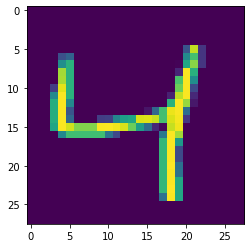

In [37]:
# To plot an image

def plot(image):
    image = image.reshape(28, 28)
    plt.imshow(image)

plot(some_digit)

Under the hood Scikit-Learn uses the OvO strategy: it trained 45 binary classifiers got their decision scores for the image and then selected the class that won the most duels.

If you call the decision function() method you will see that it returns 10 scores per instance instead of just 1.
We then choose the class with the highest score.

In [38]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 0.71537935, -0.29662415,  5.21971626,  6.21824425,  9.30389385,
         3.80284658,  1.79830476,  7.24440738,  2.74262663,  8.25740666]])

In [39]:
# Highest score and the corresponding class
np.argmax(some_digit_scores)
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

When classifier is trained, it stores a list of target classes in its classes_ attribute.

If you want to force Scikit-Learn to use OvO or OvR then use the OneVsOneClassifier of OneVsRestClassifier.

Simply create an instance and pass a classifier to its constructor (it does not even have to be binary). For example this code creates a multiclass classifier using the OvR strategy based on an SVC.

In [40]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([4], dtype=uint8)

## 5. Error Analysis

After the model is made to improve it we could explore data preparation options, try out multiple models and fine tune their parameters using GridSearchCV, and automate as much as possible. Assuming that you have found a promising model and want to find ways to improve we could analyse the types of errors it makes.

First we will look at the confusion matrix, you need to make predictions using the cross_val_predict function, then call the confusion matrix function.

In [41]:
# First lets scale the inputs
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [42]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

It is often better to look at an image representation of the confusion matrix using Matplotlib **matshow** function

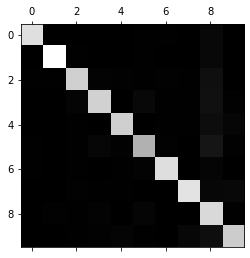

In [43]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

This confusion matrix looks good since most imahes a on the main diagonal which means that they were classified correctly. The 5s look slightly darker which could mean there are fewer imahes of 5 or that it did not perform as well on 5s.

To focus on the plot on the errors. First we need to divide each value in confusion matrix by the number of images in the corresponding class, so you can compare error rates instead of absolute number of errors (which would make abundant classes look unfairly bad).

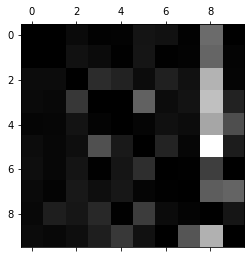

In [44]:
row_sums = conf_mx.sum(keepdims=True)
norm_conf_mx = conf_mx / row_sums

# Fill diagonals with zero to keep only the errors
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Looking  at the matrix, you can see the kind of errors being made, the column represnets predicted classes while rows represent actual classes.
The column for class 8 is bright which means many images are getting misidentified as 8 but row for 8 is fine which means the images that are of 8 are getting properly identified.
The confusion matrix is not necessarily symmetrical.

Analysing it we can see what steps to take to improve the performance of the model. We need to for example try to reduce the number of false 8s. This can be done by getting more training data for digits that look like 8s but are not so that classifier can distinguish them from the real 8s.
Or you could engineer new features that would help the classifier such as an algorithm to count the number of closed loops for example 8 has two, 6 has one and 5 has no loops.
Or you could preprocess the images using Scikit-Image, Pillow or OpenCv to make certain patterns like closed loops stand out more.

Analysing individual errors can also be a good way to gain insgihts on what your classifier is doing and why its failing. But it is more difficult and time consuming.

## 6. Multilabel Classification

In the examples given above each instance is assigned to just one class. In some cases you may want your classifier to output multiple classes for each instance. Consider a face recognition classifier, What should u do if it recognises several people in the same picture. It should attach one tag per person it recognises. If the classifier has been trained to recognise Alice, Bob, Charlie. Then when the classifier is shown a picture of Alice and Charlie, it should output [1, 0, 1] meaning Alice yes, Bob no, Charlie yes. Such a classification system that identifies multilpe binar tags is called a multilabel classification system.
For example:

In [46]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >=7)
y_train_odd = (y_train %2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

In [47]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

This code creates a y_multilabel array containing two target labels for each digit image, the first indicates whether or not digit is large and second if it is odd. The next lines creates a classifier (which supports multilabel classification, all classifiers do not support) and we train it using the multiple targets array, Now you can make a prediction and notice that it outputs two labels.

In [48]:
# This result should give us [False, False] as 4 is <7 and is not odd.
knn_clf.predict([some_digit])

array([[False, False]])

There are many ways to evaluate a multilabel classifier and selecting the right metric really depends on the project, One process is to measure the F1 score for each individual label (or any other metric) and then compute the average score.

In [49]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

This assumes that all labels are equally important, that may not be the case in particular oif you have many more pictures of Alice than of the other two, you may want to give more weight to classifiers score on pictures of Alice. Simple option is to give each label a weight equal to its support (number of instances with that target label). TO do this set **average="weighted"**.

## 7. Multioutput Classification

Multioutput classification is simply a generalisation of multilabel classification where each label can be multiclass, it can have more than two possible values.

To illustrate this lets build a system that removes noise from images, it will input a noisy digit image and output a clean digit image, represented as an array of pixel intensities, just like the MNIST images. Notice that the classifiers output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0-255). Thus it is an example of multioutput classification.

The line between classification and regression is sometimes blurry, such as here, As arguable pixel intensity is a regression problem. However, multioutput systems are not limited to classification tasks, you could even have a system that outputs multiple labels per instance, including class labels and value labels.

Start by creating the train and test sets b y taking the MNIST images and adding noise to their pixel intensities with numpy randint function. The target image will be the original images.

In [55]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

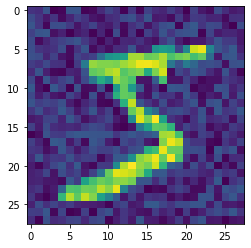

In [61]:
# What the noise image looks like
plot(X_train_mod.loc[0].to_numpy())

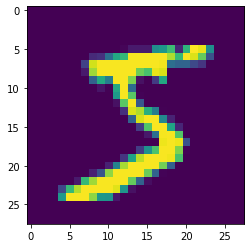

In [62]:
# What actual image looks like
plot(y_train_mod.loc[0].to_numpy())

In [72]:
# To clean image
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod.loc[60000]])

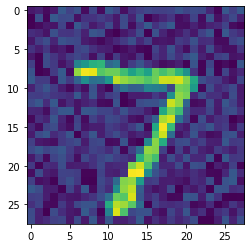

In [76]:
# Before cleaning
plot(X_test_mod.loc[60000].to_numpy())

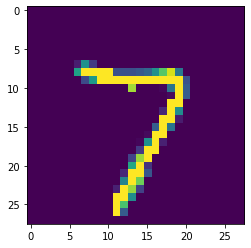

In [77]:
# After cleaning
plot(clean_digit)

This concludes the section on classification.

## 8. Exercises

1. Try to build a classifier for the MNIST datasets that achieves over 97% accuracy on the test set. Hint: The KNeighborsClassifier works well for this task: you need to find good hyperparameter values (try using grid search on weights and n_neighbors hyperparameters).
2. Write a function that can shift an MNIST image in any direction (left, right, up, down) by 1 pixel. The for each image in the training set create four shifted copies and add them to the training set. Finally, train your best model on the expanded training set and measure accuracy on test set, This should make the model work better, technique is called data augmentation or training set expansion.
3. Tackle the titanic dataset. A great place to start is on Kaggle: https://www.kaggle.com/c/titanic
4. Build a spam classifier: -
a. Download examples of spam and ham for Apache SpamAssassins public datasets: https://homl.info.spamassasin
b. Unzip the dataset and familiarize with the format
c. Split the dataset into training and test set.
d. Write a data preparation pipeline to convert each email into a feature vector. The pipeline should convert an email into a sparse vector that indicates the presence or absence of each possible word, For example, if all emails only contain 4 words: "Hello", "how", "are", "you" then the email "Hello you Hello Hello you" would be converted into vector [1,0, 0, 1](meaning "Hello" is present "how", "are" are absent and "you" is present or it could be [3, 0, 0, 2] if you want to count the occurrences.
e. You may want to add hyperparameters to your preparation pipeline to control whther or not to strip off email headers, convert each email to lowercase, remove punctuation replace all URLS with "URL" replace all numbers with "NUMBER" or even perform stemming (trim off word ending, there python libraries available to do this.
f. Finally, try out several classifiers and see if you can build a good spam classifier with high precision and high recall.
